In [1]:
# import pandas as pd
import modin.pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import confusion_matrix_pretty_print
from confusion_matrix_pretty_print import plot_confusion_matrix_from_data

from sklearn.metrics import confusion_matrix,classification_report,precision_score, auc, precision_recall_curve, roc_curve

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Softmax, Dropout, MaxPooling2D
from keras import optimizers
from keras import metrics as kmetr
from keras.utils import plot_model

import pydot

Using TensorFlow backend.
/home/amin/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/amin/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/amin/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/amin/.local/lib/python3.6/site-packages/tensorflow/python/framewo

In [2]:
#### test & train split
data = pd.read_csv('../saved F(Drug-Disease).csv')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075
0,D102100,DB00014,0,1.00000,0.44574,0.25000,0.52140,0.27515,0.05046,0.17621,...,0.03072,0.14301,0.0,0.0,0.0,0.0,0.0,0.094405,0.12665,0.0
1,D102100,DB00035,0,0.44574,1.00000,0.28249,0.63184,0.20779,0.05732,0.28302,...,0.03072,0.14301,0.0,0.0,0.0,0.0,0.0,0.094405,0.12665,0.0
2,D102100,DB00091,0,0.25000,0.28249,1.00000,0.33880,0.14734,0.15278,0.30108,...,0.03072,0.14301,0.0,0.0,0.0,0.0,0.0,0.094405,0.12665,0.0
3,D102100,DB00104,0,0.52140,0.63184,0.33880,1.00000,0.24138,0.06358,0.18717,...,0.03072,0.14301,0.0,0.0,0.0,0.0,0.0,0.094405,0.12665,0.0
4,D102100,DB00115,0,0.27515,0.20779,0.14734,0.24138,1.00000,0.02730,0.09976,...,0.03072,0.14301,0.0,0.0,0.0,0.0,0.0,0.094405,0.12665,0.0


In [3]:
# data.iloc[:int(0.9*len(data.iloc[:,2])),:].to_csv('../trainSaved F(Drug-Disease).csv',index=False)
# data.iloc[int(0.9*len(data.iloc[:,2])):,:].to_csv('../testSaved F(Drug-Disease).csv',index=False)
                 
# del data

In [4]:
# dataTrain = pd.read_csv('../trainSaved F(Drug-Disease).csv')
# dataTest = pd.read_csv('../testSaved F(Drug-Disease).csv')
# dataTest = pd.read_csv('../../triple_cosineSNF(zeros).csv')
# print(dataTest.shape,dataTrain.shape)

In [7]:
dataTrain = data.iloc[int(0.2*len(data.iloc[:,2])):,:]
dataTest = data.iloc[:int(0.2*len(data.iloc[:,2])),:]

In [8]:
X_train = dataTrain.values[:,3:]
y_train = dataTrain.values[:,2].astype(int)
del dataTrain
trainNum = len(X_train)
X_test = dataTest.values[:,3:]
y_test = dataTest.values[:,2].astype(int)
# del dataTest
testNum = len(X_test)

#reshape data to fit model
X_train = X_train.reshape(trainNum,16,67,1)
X_test = X_test.reshape(testNum,16,67,1)

# y_train = y_train + 1
# y_test  = y_test + 1
# y_train = y_train / 2
# y_test  = y_test / 2
print(y_train[0:5], y_test[0:5])

#one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_test[0]


[0 0 0 0 0] [0 0 0 0 0]


array([1., 0.], dtype=float32)

In [9]:
print(y_train[0:5], y_test[0:5])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]] [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [10]:
# #create model
# model = Sequential()
# #add model layers
# # kernel_initializer='uniform',
# # kernel_initializer='uniform',
# # kernel_initializer='uniform',
# # kernel_initializer='uniform',
# model.add(Conv2D(128, kernel_size=4, activation='relu', input_shape=(16,71,1)))
# # model.add(Conv2D(64, kernel_size=2, activation='relu'))

# model.add(Conv2D(32, kernel_size=4, activation='relu'))
# # model.add(Conv2D(16, kernel_size=2, activation='relu'))
# model.add(Conv2D(8, kernel_size=4, activation='relu'))
# model.add(Flatten())
# # model.add(Dense( 64, activation='relu'))
# model.add(Dense( 32, activation='relu'))
# # model.add(Dropout(0.2))
# model.add(Dropout(0.4))
# # model.add(Dense( 16, activation='relu'))
# model.add(Dense( 8, activation='relu'))
# model.add(Dropout(0.4))
# model.add(Dense( 2, activation='sigmoid'))
# # model.add(Softmax(128))
# model.summary()

#create model
model = Sequential()
#add model layers
# kernel_initializer='uniform',
# kernel_initializer='uniform',
# kernel_initializer='uniform',
# kernel_initializer='uniform',
model.add(Conv2D(128, kernel_size=4, activation='relu', input_shape=(16,67,1)))
model.add(Conv2D(64, kernel_size=4, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=4, activation='relu'))
# model.add(Conv2D(16, kernel_size=4, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(8, kernel_size=4, activation='relu'))
model.add(Flatten())
model.add(Dense( 64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense( 16, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
# model.add(Softmax(128))
model.summary()


adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
# model.compile(loss='hinge', optimizer=adam, metrics=[kmetr.categorical_accuracy])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) ## Minist

### Load the model's saved weights.
# model.load_weights('cnn_4_epoch.h5')





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 64, 128)       2176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 61, 64)        131136    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 58, 32)         32800     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 55, 8)          4104      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1760)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                112704    
_

In [11]:
# #### plotting model
# plot_model(model,show_shapes = True, to_file='model .png')

In [12]:
#### train the model

#compile model using accuracy to measure model performance
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_train),
#                                                  y_train)
class_weight = {0: 0.01,
                1: 0.99
               }


history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4, class_weight=class_weight)
# history = model.fit(X_train, y_train, epochs=1)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 216934 samples, validate on 54233 samples
Epoch 1/4
216934/216934 [==============================] - 2472s 11ms/step - loss: 0.1534 - acc: 0.9903 - val_loss: 0.1323 - val_acc: 0.9918
Epoch 2/4
216934/216934 [==============================] - 2155s 10ms/step - loss: 0.1535 - acc: 0.9904 - val_loss: 0.1323 - val_acc: 0.9918
Epoch 3/4
216934/216934 [==============================] - 2171s 10ms/step - loss: 0.1535 - acc: 0.9904 - val_loss: 0.1323 - val_acc: 0.9918
Epoch 4/4
216934/216934 [==============================] - 2168s 10ms/step - loss: 0.1535 - acc: 0.9904 - val_loss: 0.1323 - val_acc: 0.9918


In [13]:
### Saveing the Model
model.save_weights('cnn_3_epoch.h5')


In [14]:
predit = model.predict(X_test)
#actual results for first 4 images in test set
print(predit[:4])



[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [15]:
# #from sklearn.metrics import precision_recall_curve, roc_curve

prec, rec, thr = precision_recall_curve(y_test[:,1], predit[:,1])
aupr_val = auc(rec, prec)
fpr, tpr, thr = roc_curve(y_test[:,1], predit[:,1])
auc_val = auc(fpr, tpr)
print(aupr_val,auc_val)

0.5041026681171981 0.5


In [16]:
model.history.history

{'acc': [0.9902689297205601,
  0.9903795624475646,
  0.9903795624475646,
  0.9903795624475646],
 'loss': [0.15344775426133572,
  0.15351250397280958,
  0.15351250399180122,
  0.15351250404859917],
 'val_acc': [0.991794663765604,
  0.991794663765604,
  0.991794663765604,
  0.991794663765604],
 'val_loss': [0.13225449628464017,
  0.13225449628464017,
  0.13225449628464017,
  0.13225449628464017]}

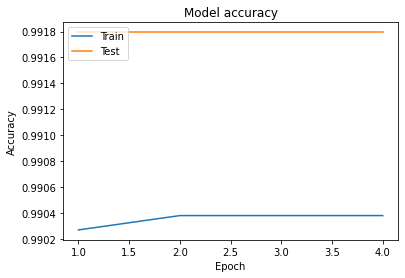

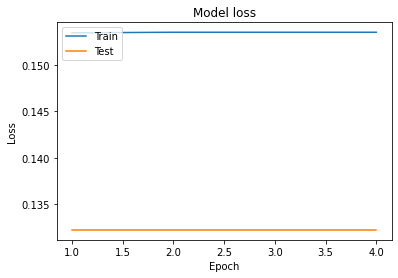

In [17]:

# Plot training & validation accuracy values
plt.plot(list(range(1,5)),model.history.history['acc'])
plt.plot(list(range(1,5)),model.history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(list(range(1,5)),model.history.history['loss'])
plt.plot(list(range(1,5)),model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
# # predit
# predit[:,0].shape 

In [19]:
predicts = []
for a,b in predit:
    if a >=b:
        predicts.append(0)
    else:
        predicts.append(1)
len(predicts)

54233

In [20]:
# predicts1 = []
# e = d = z = 0

# for a,b in predit:
#     if a >=0.90:
#         predicts1.append(0)
#         d += 1
#     elif b>=0.95:
#         predicts1.append(2)
#         e += 1
#     elif a<=0.05 and b<=0.1:
#         predicts1.append(1)
#         z += 1
# print('degrassive', d, 'enhancive', e, 'zeros', z)
# print("""
# Epoch04: degrassive 224 enhancive 2939 zeros 40
# Epoch05: degrassive 280 enhancive 2823 zeros 39
# Epoch06: degrassive 233 enhancive 2879 zeros 79
# Epoch07: degrassive 203 enhancive 2926 zeros 134
# Epoch08: degrassive 224 enhancive 2895 zeros 180
# Epoch09: degrassive 191 enhancive 2856 zeros 191
# Epoch10: degrassive 189 enhancive 2821 zeros 246
# Epoch11: degrassive 164 enhancive 2581 zeros 235
# Epoch12: degrassive 166 enhancive 2454 zeros 266
# """)

In [21]:
# max(list((dataTest.values[:,2]+1)/2))

[[53788   445]
 [    0     0]]


/home/amin/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00     53788
           1       0.00      0.00      0.00       445

    accuracy                           0.99     54233
   macro avg       0.50      0.50      0.50     54233
weighted avg       0.98      0.99      0.99     54233



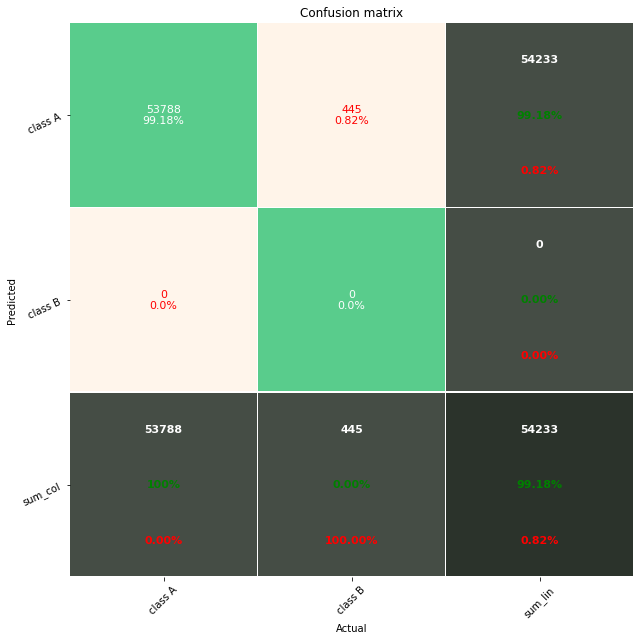

In [22]:

cm = confusion_matrix(list(predicts), list((dataTest.values[:,2])))
print(cm)

CR = classification_report(list((dataTest.values[:,2])),list(predicts))
print(CR)
# print(145/4702)
# i=0
# for j in list(data.values[9500:,2]+1):
#     if j==1:
#         i +=1
# print(i)

# plt.show()
plot_confusion_matrix_from_data(list((dataTest.values[:,2])), list(predicts))


In [23]:
print(pd.DataFrame(predit))

         0    1
0      1.0  0.0
1      1.0  0.0
2      1.0  0.0
3      1.0  0.0
4      1.0  0.0
...    ...  ...
54228  1.0  0.0
54229  1.0  0.0
54230  1.0  0.0
54231  1.0  0.0
54232  1.0  0.0

[54233 rows x 2 columns]


LinAlgError: singular matrix

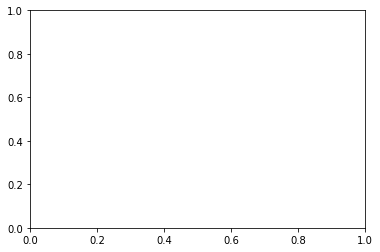

In [24]:
pd.DataFrame(predit).plot.density()


In [ ]:
pd.DataFrame(predit).iloc[:,0].plot.density()

In [ ]:
pd.DataFrame(predit).iloc[:,1].plot.density()

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)

# matplotlib histogram
# plt.hist(pd.DataFrame(predit).iloc[:,1], color = 'blue', edgecolor = 'black',
#          bins = int(200))

# seaborn histogram
sns.distplot(pd.DataFrame(predit).iloc[:,1], hist=True, kde=False, 
             bins=int(100), color = 'blue',
             hist_kws={'edgecolor':'black'})

# sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=True, 
#              bins=int(200), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})
# Add labels
plt.title('frequency Histogram of Drugs')
plt.xlabel('Interaction drugs Probability')
plt.ylabel('frequency distribution')


In [ ]:

fig, ax = plt.subplots()
fig.set_size_inches(16,8)

# matplotlib histogram
# plt.hist(pd.DataFrame(predit).iloc[:,1], color = 'blue', edgecolor = 'black',
#          bins = int(200))

# seaborn histogram

sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=False, 
             bins=int(100), color = 'red',
             hist_kws={'edgecolor':'black'})
# sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=True, 
#              bins=int(200), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})
# Add labels
plt.title('frequency Histogram of Drugs')
plt.xlabel('None Interaction drugs Probability')
plt.ylabel('frequency distribution')

In [ ]:

fig, ax = plt.subplots()
fig.set_size_inches(16,8)

# matplotlib histogram
# plt.hist(pd.DataFrame(predit).iloc[:,1], color = 'blue', edgecolor = 'black',
#          bins = int(200))

# seaborn histogram
sns.distplot(pd.DataFrame(predit).iloc[:,1], hist=True, kde=False, 
             bins=int(100), color = 'blue',
             hist_kws={'edgecolor':'black'})

sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=False, 
             bins=int(100), color = 'red',
             hist_kws={'edgecolor':'black'})
# sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=True, 
#              bins=int(200), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})
# Add labels
plt.title('frequency Histogram of Drugs')
plt.xlabel('all drugs Probability')
plt.ylabel('frequency distribution')